In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import zeros
from termcolor import colored
from numpy.random import normal

from tensorflow.keras.datasets.mnist import load_data
plt.style.use("seaborn")

<ipython-input-1-79edff15e9ff>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
(train_images, train_labels), test_ds = load_data()
print(type(train_images), type(train_labels)) ## <class 'numpy.ndarray'> <class 'numpy.ndarray'>
print(train_images.shape, train_labels.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(60000, 28, 28) (60000,)


(9, 28, 28)


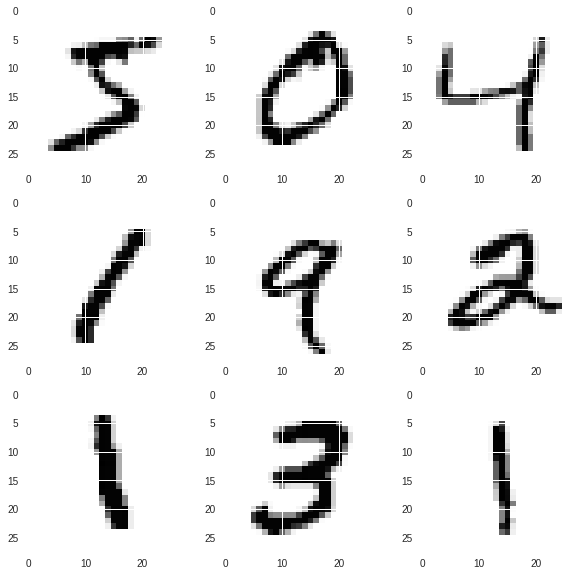

In [3]:
view_images = train_images[:9, ...]
print(view_images.shape)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax_idx, ax in enumerate(axes.flat):
    image = view_images[ax_idx]
    ax.imshow(image)

In [4]:
## Set test env
n_data = train_images.shape[0]
n_feature = train_images.shape[1] * train_images.shape[2]
batch_size = 64
n_batch = n_data // batch_size
epochs = 20
lr = 0.03
units = [64, 32, 10] ## neurons per layer

In [5]:
## initialize W, B
W1 = normal(0, 1, (n_feature, units[0]))
B1 = zeros((units[0]))
W2 = normal(0, 1, (units[0], units[1]))
B2 = zeros((units[1]))
W3 = normal(0, 1, (units[1], units[2]))
B3 = zeros((units[2]))
print(colored("W/B Shapes", 'green'))
print(f"W1/B1: {W1.shape}/{B1.shape}")
print(f"W2/B2: {W2.shape}/{B2.shape}")
print(f"W3/B3: {W3.shape}/{B3.shape}\n")

W/B Shapes
W1/B1: (784, 64)/(64,)
W2/B2: (64, 32)/(32,)
W3/B3: (32, 10)/(10,)



[keepdims에 관한 설명](https://jimmy-ai.tistory.com/116)

In [6]:
losses, accs = [], []
for epoch in range(epochs):
    num_correct, num_data = 0, 0
    for batch_idx in range(n_batch):
        ## Get mini-batch
        images = train_images[batch_idx * batch_size : (batch_idx + 1) * batch_size, ...]
        X = images.reshape(batch_size, -1) / 255.
        Y = train_labels[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        # print(X.shape, Y.shape) ## (64, 784) (64,)

        ## Forward propagation
        ## Dense1
        Z1 = X @ W1 + B1
        A1 = 1 / (1 + np.exp(-Z1))

        ## Dense2
        Z2 = A1 @ W2 + B2
        A2 = 1 / (1 + np.exp(-Z2))

        ## Dense3
        L = A2 @ W3 + B3 ## Logit Matrix
        # print(L.shape) ## batch_size, 10

        ## Loss
        pred = np.exp(L) / np.sum(np.exp(L), axis=1, keepdims=True) ## Softmax. keepdims를 통해 N, 10 shape을 유지한다.
        J = np.mean(-np.log(pred[np.arange(batch_size), Y])) ## 각 row마다 label값에 해당하는 위치의 prob을 가져온다.(indexing)
        losses.append(J)

        ## Calculate accuracy
        pred_label = np.argmax(pred, axis=1) ## 각 row마다 최댓값인 확률을 구한다.
        num_correct += np.sum(pred_label == Y) ## 128개 128개 간의 비교. 두 개 값이 동일한 경우를 모두 더함.
        num_data += batch_size

        ## Backpropagation
        labels = Y.copy()
        Y = np.zeros_like(pred)
        Y[np.arange(batch_size), labels] = 1

        ## Loss
        dL = -1 / batch_size * (Y - pred)

        ## Dense3
        dA2 = dL @ W3.T
        dW3 = A2.T @ dL
        dB3 = np.sum(dL, axis=0)

        ## Dense2
        dZ2 = dA2 * A2 * (1 - A2)
        dA1 = dZ2 @ W2.T
        dW2 = A1.T @ dZ2
        dB2 = np.sum(dZ2, axis=0)

        ## Dense1
        dZ1 = dA1 * A1 * (1 - A1)
        dW1 = X.T @ dZ1
        dB1 = np.sum(dZ1, axis=0)

        ## Parameter Update
        W3, B3 = W3 - lr * dW3, B3 - lr * dB3
        W2, B2 = W2 - lr * dW2, B2 - lr * dB2
        W1, B1 = W1 - lr * dW1, B1 - lr * dB1

    accs.append(num_correct / num_data)

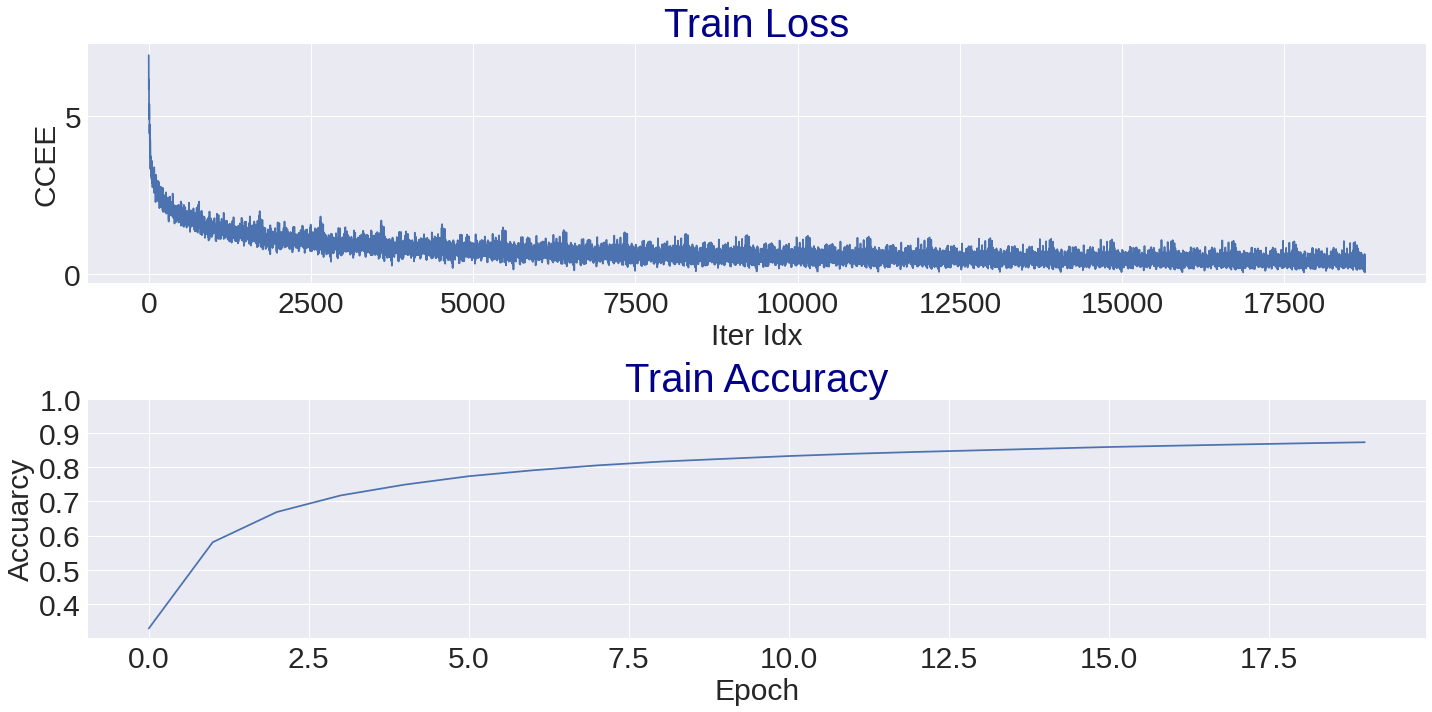

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(losses)
axes[1].plot(accs)
axes[0].set_title("Train Loss", color='darkblue', fontsize=40)
axes[0].set_xlabel("Iter Idx", fontsize=30)
axes[0].set_ylabel("CCEE", fontsize=30)
axes[1].set_title("Train Accuracy", color='darkblue', fontsize=40)
axes[1].set_xlabel("Epoch", fontsize=30)
axes[1].set_ylabel("Accuarcy", fontsize=30)
axes[1].set_yticks(np.linspace(0.4, 1.0, 7))
axes[0].tick_params(labelsize=30)
axes[1].tick_params(labelsize=30)
fig.tight_layout()